In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [30]:
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/data/empty_board.png"
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/full_board.png"




In [53]:


image = cv2.imread(image_path)
print(image.shape)
size_of_board = (image.shape[0]+image.shape[1])/2

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150, apertureSize=3)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 900)



(1116, 1132, 3)


In [54]:
line_image = image.copy()
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_of_board * (-b))
        y1 = int(y0 + size_of_board * (a))
        x2 = int(x0 - size_of_board * (-b))
        y2 = int(y0 - size_of_board * (a))
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)


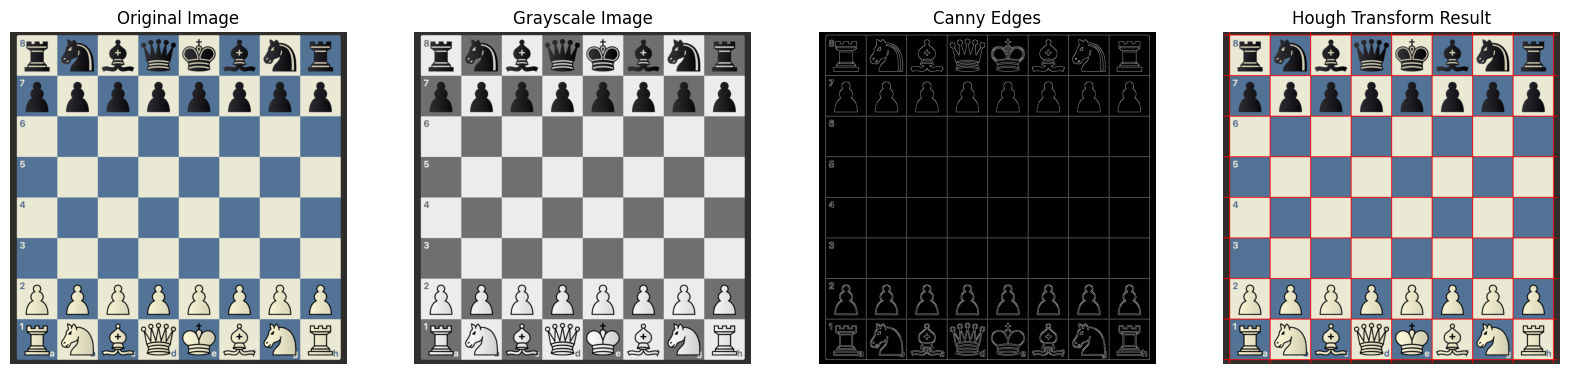

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis("off")

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edges")
axes[2].axis("off")

axes[3].imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
axes[3].set_title("Hough Transform Result")
axes[3].axis("off")

plt.show()

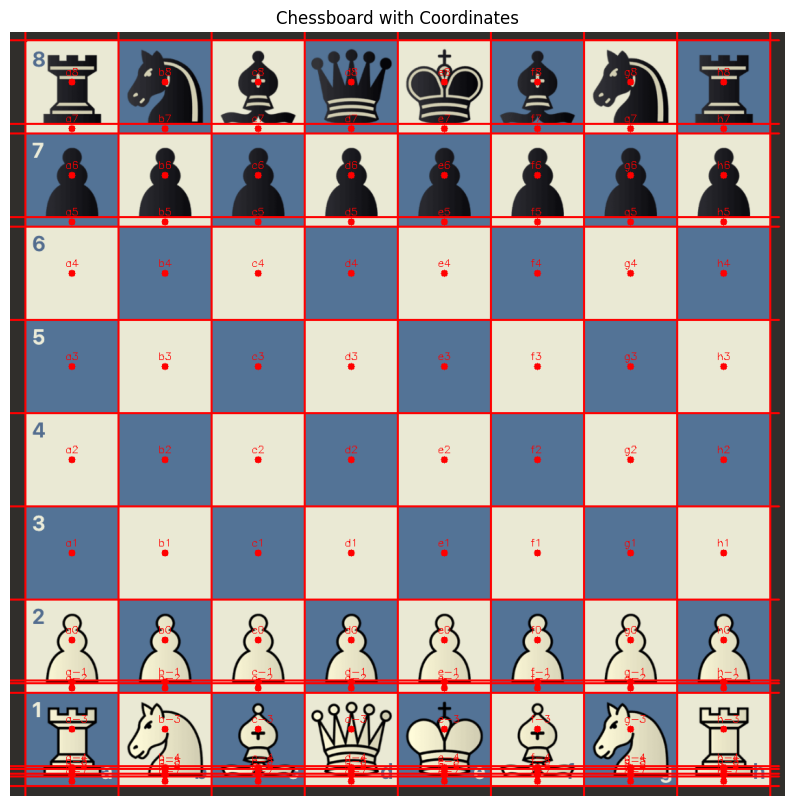

In [34]:
# Find intersections of lines
def find_intersections(lines):
    intersections = []
    if lines is None:
        return intersections
    for line1, line2 in itertools.combinations(lines, 2):
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        A = np.array([
            [np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]
        ])
        b = np.array([[rho1], [rho2]])
        if np.linalg.det(A) != 0:  # Lines are not parallel
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:  # Within image bounds
                intersections.append((x0, y0))
    return intersections

intersections = find_intersections(lines)

# Sort intersections into a grid
def sort_intersections(intersections):
    intersections.sort(key=lambda x: (x[1], x[0]))  # Sort by y, then by x
    grid = []
    grid_size = 9  # 8x8 board has 9 lines
    for i in range(0, len(intersections), grid_size):
        row = sorted(intersections[i:i + grid_size], key=lambda x: x[0])
        grid.append(row)
    return grid

grid = sort_intersections(intersections)

# Labels for the chessboard
coordinate_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

# Draw red dots and labels on the chessboard
for i in range(len(grid) - 1):
    for j in range(len(grid[i]) - 1):
        # Get the four corners of the square
        top_left = grid[i][j]
        top_right = grid[i][j + 1]
        bottom_left = grid[i + 1][j]
        bottom_right = grid[i + 1][j + 1]
        
        # Calculate the center of the square
        center_x = (top_left[0] + top_right[0] + bottom_left[0] + bottom_right[0]) // 4
        center_y = (top_left[1] + top_right[1] + bottom_left[1] + bottom_right[1]) // 4
        
        # Label for the square
        label = f"{coordinate_labels[j]}{8 - i}"
        
        # Draw the red dot at the center
        cv2.circle(line_image, (center_x, center_y), 5, (0, 0, 255), -1)
        
        # Draw the label near the center
        cv2.putText(line_image, label, (center_x - 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Display the final image with labels
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Coordinates")
plt.axis("off")
plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChessPieceCNN(nn.Module):
    def __init__(self, num_classes=13):  # Adjust the number of classes as needed
        super(ChessPieceCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

In [24]:
import os
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class ChessPieceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {
            'black_bishop': 0, 'black_king': 1, 'black_queen': 2, 'black_knight': 3, 'black_rook': 4,
            'black_pawn': 5, 'white_bishop': 6, 'white_king': 7, 'white_queen': 8, 'white_knight': 9,
            'white_rook': 10, 'white_pawn': 11, 'empty': 12
        }

        self.load_images(os.path.join(root_dir, 'black'))
        self.load_images(os.path.join(root_dir, 'white'))
        self.load_images(os.path.join(root_dir, 'empty'), is_empty=True)
    
    def load_images(self, color_dir, is_empty=False):
        if is_empty:
            for img_name in os.listdir(color_dir):
                img_path = os.path.join(color_dir, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's a valid image file
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx['empty'])
        else:
            color_label = os.path.basename(color_dir)  # Get color from the path (black or white)
            for label_name in os.listdir(color_dir):
                label_dir = os.path.join(color_dir, label_name)
                if os.path.isdir(label_dir):  # Ensure it's a directory
                    for img_name in os.listdir(label_dir):
                        img_path = os.path.join(label_dir, img_name)
                        if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure it's a valid image file
                            full_label_name = f"{color_label}_{label_name}"
                            self.images.append(img_path)
                            self.labels.append(self.class_to_idx[full_label_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        
        image = Image.open(img_path).convert('RGB')

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label


In [25]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [26]:
train_dataset = ChessPieceDataset(root_dir='data/train', transform=train_transform)
test_dataset = ChessPieceDataset(root_dir='data/test', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for idx in range(5): 
    img, lbl = train_dataset[idx]
    print(f"Image path: {train_dataset.images[idx]}, Label: {train_dataset.labels[idx]}, Class name: {list(train_dataset.class_to_idx.keys())[lbl]}")

Image path: data/train/black/bishop/augmented_screenshot_45 2024-06-07 at 13.52.03.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/augmented_screenshot_38 2024-06-07 at 13.51.58.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/augmented_screenshot_20 2024-06-07 at 13.52.00.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/augmented_screenshot_34 2024-06-07 at 13.52.09.png, Label: 0, Class name: black_bishop
Image path: data/train/black/bishop/augmented_screenshot_87 2024-06-07 at 13.52.03.png, Label: 0, Class name: black_bishop


In [28]:
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

# Initialize the model, loss function, and optimizer
model = ChessPieceCNN(num_classes=13)  # Including 'empty' as a class
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and testing loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

best_test_acc = 0
best_train_acc = 0

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Training and testing loop
for epoch in tqdm(range(100)):  # Number of epochs
    model.train()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += calculate_accuracy(outputs, labels) * labels.size(0)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_corrects / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Confusion matrix for training
    cm_train = confusion_matrix(all_labels, all_preds)
    print(f"\nEpoch {epoch+1} Training Confusion Matrix")
    print(cm_train)

    # Evaluate on test set
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            test_running_corrects += calculate_accuracy(outputs, labels) * labels.size(0)
            all_test_preds.extend(outputs.argmax(1).cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
    
    test_loss = test_running_loss / len(test_loader)
    test_accuracy = test_running_corrects / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_accuracy > 0.9:
        best_test_acc = test_accuracy
        if train_accuracy > best_train_acc:
            best_train_acc = train_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            epoch_saved = epoch

    # Confusion matrix for testing
    cm_test = confusion_matrix(all_test_labels, all_test_preds)
    print(f"\nEpoch {epoch+1} Testing Confusion Matrix")
    print(cm_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print('Finished Training')
print(f'Model saved at train_acc {best_train_acc}, and test_acc {best_test_acc}, at epoch {epoch_saved}')


  1%|          | 1/100 [01:11<1:57:20, 71.11s/it]


Epoch 1 Training Confusion Matrix
[[650  10   3  11  44  52  16   5   6   8   5  10  24]
 [ 13 575  39  22   3  11   5   5  28  10   6   4   6]
 [ 19  24 576  19  12  15   0   3  33   5   7   7   6]
 [ 24   7  10 715   8  54   1   0   2   6   1   8  11]
 [ 35   1  13  18 659  47   7   7   7  10  15  14  16]
 [ 46   2   6  34  26 754  10   5   3   9   5   9  22]
 [ 31   1   2   2   5   9 608  38  18  17  33  47  34]
 [  6   3   1   1   7   4  23 535  24  34  31  31  25]
 [  6  11  32   3   7   3   8  14 571  15  25  22   9]
 [  8   0   1   5   5   1   5  30  16 651  22  37  65]
 [  5   0   4   3  29   4  34  27  29  23 623  37  27]
 [ 11   0   2   8   2   7  32  13  20  30  36 582  75]
 [ 12   2   5  28   1  26   4   8   8  27   5  41 842]]

Epoch 1 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 1, Train Loss: 0.83

  2%|▏         | 2/100 [02:22<1:56:29, 71.32s/it]


Epoch 2 Training Confusion Matrix
[[798   2   1   3   1  31   5   0   0   2   0   0   1]
 [  4 696   8   7   2   1   1   3   2   0   0   2   1]
 [  3   4 693   4   1   3   0   0  14   0   0   1   3]
 [  0   2   1 819   3  12   1   0   1   6   1   0   1]
 [  0   0   1   3 817  14   0   1   0   1   8   2   2]
 [ 21   0   2   6   8 866   3   1   0   1   0  15   8]
 [  3   0   0   0   0   2 794   7   1   1  10  19   8]
 [  1   5   2   0   1   0   4 686   4  13   4   2   3]
 [  0   0  13   2   0   0   0   7 684   7   6   5   2]
 [  0   1   1   1   1   1   4   7   2 796   3  11  18]
 [  0   0   0   0   5   3   8   3   2   7 798  10   9]
 [  3   0   2   0   0   1  12   4   0  15   6 761  14]
 [  0   0   0   0   0   2   0   1   1  18   0   6 981]]

Epoch 2 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 2, Train Loss: 0.22

  3%|▎         | 3/100 [03:31<1:53:53, 70.45s/it]


Epoch 3 Training Confusion Matrix
[[807   0   0   2   2  22   6   2   1   0   0   2   0]
 [  2 708   3   7   1   1   0   3   1   1   0   0   0]
 [  0   3 703   6   0   3   0   0   8   2   1   0   0]
 [  2   3   2 818   4   9   0   0   0   6   1   2   0]
 [  1   0   2   4 822  11   0   0   1   0   7   1   0]
 [ 19   0   1   6   6 872   7   0   0   0   0  14   6]
 [  0   0   0   0   0   0 828   3   1   1   2   7   3]
 [  0   1   0   1   0   1   1 704   5   5   3   1   3]
 [  0   0   5   1   0   0   0   5 703   3   3   3   3]
 [  0   0   0   3   1   1   1   1   2 815   5   6  11]
 [  0   0   0   0   5   1   0   0   2   4 820   7   6]
 [  0   0   0   0   0   7   3   3   2   8   8 774  13]
 [  0   0   0   0   0   2   1   0   1  11   0   1 993]]

Epoch 3 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 3, Train Loss: 0.15

  4%|▍         | 4/100 [04:42<1:52:46, 70.49s/it]


Epoch 4 Training Confusion Matrix
[[802   2   5   1   2  20   9   0   0   0   0   1   2]
 [  1 709   3   7   1   0   1   2   3   0   0   0   0]
 [  5   4 703   5   1   1   0   0   5   2   0   0   0]
 [  1   4   1 818   4   8   1   1   1   7   1   0   0]
 [  1   1   2   3 820   9   0   0   0   1   8   2   2]
 [ 10   0   0   5   3 881   4   0   0   1   1  22   4]
 [  4   0   0   0   0   3 811   6   2   2   2  11   4]
 [  1   0   1   0   0   3   2 706   5   5   1   0   1]
 [  0   2   4   0   1   0   0   1 709   5   2   0   2]
 [  1   0   0   5   0   1   3   2   2 810   5   5  12]
 [  0   0   0   0   6   0   1   0   0   8 820   5   5]
 [  0   0   0   0   0   6   5   0   2   5   1 786  13]
 [  0   0   0   2   0   1   0   0   0  11   0   1 994]]

Epoch 4 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 2]]
Epoch 4, Train Loss: 0.14

  5%|▌         | 5/100 [05:52<1:51:04, 70.15s/it]


Epoch 5 Training Confusion Matrix
[[815   0   0   2   1  13   9   2   0   0   0   2   0]
 [  0 710   1   8   1   1   0   3   1   1   0   1   0]
 [  3   4 705   7   1   0   0   0   6   0   0   0   0]
 [  0   2   2 826   2   5   1   1   1   5   1   0   1]
 [  0   1   0   2 828   6   0   1   0   0  10   1   0]
 [  4   1   1   4   1 899   2   0   1   0   1  15   2]
 [  6   0   0   0   0   3 819   3   0   1   1   9   3]
 [  0   2   0   0   0   0   2 702   7   8   4   0   0]
 [  0   0   7   0   0   0   1   5 703   5   3   0   2]
 [  0   0   0   3   0   1   1   3   2 819   4   2  11]
 [  0   0   0   0  10   0   1   2   0   3 820   7   2]
 [  1   0   2   0   0   3   5   0   1   1   4 799   2]
 [  0   0   0   0   0   1   0   1   0  10   0   0 997]]

Epoch 5 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 5, Train Loss: 0.13

  6%|▌         | 6/100 [07:02<1:50:02, 70.24s/it]


Epoch 6 Training Confusion Matrix
[[818   0   0   2   1  13   6   1   0   1   1   1   0]
 [  0 711   1   6   1   1   1   3   0   1   1   1   0]
 [  0   1 714   4   2   1   0   0   4   0   0   0   0]
 [  1   3   5 824   2   4   0   0   0   4   0   1   3]
 [  0   1   0   3 823   6   0   0   0   0  14   2   0]
 [  5   0   0   1   2 901   1   1   1   0   2  12   5]
 [  2   0   0   0   0   2 824   1   0   2   1  11   2]
 [  0   2   0   0   0   0   2 710   3   4   1   0   3]
 [  0   0  10   0   0   0   0   3 703   3   4   0   3]
 [  0   0   0   2   2   0   2   1   3 823   4   1   8]
 [  0   0   0   0   8   0   1   0   1   3 824   7   1]
 [  0   0   0   0   2   8   4   2   0  10   2 784   6]
 [  0   0   0   0   0   2   0   0   0   7   0   3 997]]

Epoch 6 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 6, Train Loss: 0.11

  7%|▋         | 7/100 [08:16<1:50:46, 71.46s/it]


Epoch 7 Training Confusion Matrix
[[815   2   3   3   1  11   8   0   0   0   0   1   0]
 [  1 709   4   2   2   2   0   4   3   0   0   0   0]
 [  3   2 712   2   0   2   0   0   3   1   0   0   1]
 [  0   0   1 824   4   8   0   0   0   7   1   2   0]
 [  1   0   0   2 829   8   0   1   1   1   6   0   0]
 [  8   0   0   3   1 897   3   0   0   0   1  13   5]
 [  5   0   1   0   0   0 824   3   1   1   1   5   4]
 [  0   2   0   0   1   0   1 707   3   5   3   3   0]
 [  0   1   4   0   0   0   3   3 708   2   2   2   1]
 [  0   0   0   2   0   1   0   3   1 818   7   5   9]
 [  0   0   0   0   3   0   2   1   2   3 825   3   6]
 [  1   0   0   2   0   5   3   1   0   8   3 787   8]
 [  0   0   0   0   0   1   0   1   3   8   0   0 996]]

Epoch 7 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 3]]
Epoch 7, Train Loss: 0.11

  8%|▊         | 8/100 [09:30<1:50:35, 72.12s/it]


Epoch 8 Training Confusion Matrix
[[ 820    0    0    1    2   15    5    0    0    0    0    0    1]
 [   0  712    2    3    2    2    0    4    0    1    1    0    0]
 [   2    2  710    4    0    4    0    0    3    0    1    0    0]
 [   0    1    1  827    1    8    0    0    0    5    2    1    1]
 [   0    0    1    1  830    7    0    0    0    0    8    2    0]
 [  12    0    1    1    0  893    2    0    0    1    0   18    3]
 [   4    0    0    0    0    2  826    2    2    1    0    7    1]
 [   1    1    0    0    1    0    3  709    5    2    1    2    0]
 [   0    1    7    0    0    0    0    0  713    2    2    0    1]
 [   0    0    0    1    0    0    1    2    2  822    3    6    9]
 [   0    0    0    0    9    1    2    1    0    4  823    3    2]
 [   0    0    0    0    0    9    6    2    2    2    2  792    3]
 [   0    0    0    2    0    0    0    0    2    4    1    0 1000]]

Epoch 8 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 

  9%|▉         | 9/100 [10:43<1:49:48, 72.40s/it]


Epoch 9 Training Confusion Matrix
[[ 822    0    1    3    0   12    5    0    0    0    0    1    0]
 [   0  706    6    7    3    1    1    1    0    1    0    0    1]
 [   3    4  706    3    0    1    0    0    9    0    0    0    0]
 [   0    1    1  829    3    1    1    0    0    6    0    0    5]
 [   1    1    1    0  830    9    0    0    0    1    5    0    1]
 [   5    1    1    6    2  896    4    0    0    0    0   13    3]
 [   4    0    0    0    0    5  820    1    0    0    1   13    1]
 [   0    0    0    0    0    0    3  710    3    5    2    0    2]
 [   0    3    6    0    0    0    0    4  709    1    3    0    0]
 [   0    1    0    3    3    0    0    1    3  820    4    1   10]
 [   1    0    0    0    4    0    2    1    0    4  826    5    2]
 [   0    1    0    0    0    8    4    0    0    3    3  795    4]
 [   0    0    0    0    0    0    0    0    0    7    1    1 1000]]

Epoch 9 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [0 

 10%|█         | 10/100 [11:56<1:48:51, 72.57s/it]


Epoch 10 Training Confusion Matrix
[[ 820    0    1    1    1   11    7    0    0    0    0    1    2]
 [   0  712    2    5    2    0    0    4    1    1    0    0    0]
 [   1    5  707    3    0    2    0    1    6    0    1    0    0]
 [   1    1    4  828    1    7    0    0    0    3    0    2    0]
 [   1    0    2    2  830    4    0    1    0    1    7    0    1]
 [   2    1    1    4    1  903    4    0    0    0    1   13    1]
 [   4    0    0    0    0    1  822    2    1    4    4    6    1]
 [   0    0    0    0    0    0    0  711    4    4    3    2    1]
 [   0    0    6    0    1    0    0    3  710    5    1    0    0]
 [   0    0    0    1    0    1    5    1    1  818    5    2   12]
 [   0    0    0    1    6    0    1    2    0    2  824    8    1]
 [   0    0    0    1    1    8    7    0    1    3    2  792    3]
 [   0    0    0    0    0    1    0    0    1    6    0    0 1001]]

Epoch 10 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 11%|█         | 11/100 [13:05<1:46:14, 71.63s/it]


Epoch 11 Training Confusion Matrix
[[ 820    0    1    1    0   12    8    0    0    1    0    1    0]
 [   0  715    2    5    1    0    1    2    1    0    0    0    0]
 [   0    4  711    4    1    0    0    0    6    0    0    0    0]
 [   0    2    2  830    2    5    0    1    0    3    0    2    0]
 [   0    0    0    1  831    6    0    0    1    0   10    0    0]
 [   3    0    0    1    2  903    1    0    0    1    0   16    4]
 [   4    1    0    0    0    0  831    1    1    0    0    4    3]
 [   0    1    0    0    0    1    0  713    1    4    2    1    2]
 [   0    1    6    0    0    0    0    4  710    3    2    0    0]
 [   0    1    0    2    1    0    3    1    3  819    3    5    8]
 [   0    0    0    0    4    0    1    2    0    5  828    3    2]
 [   1    0    1    0    0    7    3    0    0    4    2  796    4]
 [   0    0    0    0    0    0    0    0    1    6    0    0 1002]]

Epoch 11 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 12%|█▏        | 12/100 [14:15<1:44:31, 71.27s/it]


Epoch 12 Training Confusion Matrix
[[ 822    0    1    1    0   13    6    0    0    0    0    1    0]
 [   1  715    0    2    2    1    0    3    0    2    0    1    0]
 [   1    1  713    2    1    1    0    0    7    0    0    0    0]
 [   1    2    1  828    0    5    0    0    0    7    1    1    1]
 [   1    0    0    2  832    5    1    0    0    2    6    0    0]
 [   4    0    1    3    2  902    4    0    0    0    0   11    4]
 [   3    0    0    0    0    2  826    2    1    1    1    6    3]
 [   0    3    0    0    0    0    3  710    3    4    1    0    1]
 [   0    0    2    0    2    0    0    0  716    3    1    1    1]
 [   0    0    0    2    1    0    1    6    1  818    5    1   11]
 [   0    0    0    0    3    0    2    0    0    4  833    2    1]
 [   0    0    0    1    1    6    5    0    0    1    4  795    5]
 [   0    0    0    0    1    3    0    0    0    4    0    1 1000]]

Epoch 12 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 13%|█▎        | 13/100 [15:25<1:42:34, 70.74s/it]


Epoch 13 Training Confusion Matrix
[[ 826    2    0    1    1    9    3    1    0    0    0    1    0]
 [   0  711    3    2    2    3    0    4    1    0    0    1    0]
 [   3    2  712    1    0    1    1    0    6    0    0    0    0]
 [   2    2    0  826    1    8    0    0    0    5    1    1    1]
 [   0    0    0    4  830    5    0    0    1    0    8    1    0]
 [   5    2    0    4    2  901    1    0    0    0    1   12    3]
 [   3    0    0    0    0    1  833    0    1    1    0    6    0]
 [   0    4    0    0    2    0    2  707    2    4    1    3    0]
 [   0    0    5    0    0    0    0    3  716    1    1    0    0]
 [   0    0    0    1    1    0    0    3    1  828    3    3    6]
 [   0    0    0    0    7    1    0    0    0    4  828    2    3]
 [   0    0    0    0    0    8    5    3    1    2    2  794    3]
 [   0    0    0    0    0    1    0    0    0    3    1    1 1003]]

Epoch 13 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 14%|█▍        | 14/100 [16:36<1:41:39, 70.92s/it]


Epoch 14 Training Confusion Matrix
[[ 826    1    0    1    1    8    7    0    0    0    0    0    0]
 [   0  714    1    5    1    3    1    2    0    0    0    0    0]
 [   1    0  709    3    0    0    0    0   11    1    0    1    0]
 [   2    1    2  827    1    5    0    0    0    8    1    0    0]
 [   0    1    1    4  833    4    0    0    1    0    3    1    1]
 [   7    2    0    0    1  904    1    1    0    1    0   12    2]
 [   2    0    0    0    0    2  824    2    4    1    0    9    1]
 [   0    2    0    0    2    0    0  709    5    2    4    0    1]
 [   0    1   11    0    0    0    0    1  704    1    3    4    1]
 [   0    0    0    2    0    1    2    4    1  826    3    1    6]
 [   0    0    0    0    3    1    4    2    0    2  828    3    2]
 [   0    0    0    0    0    8    4    1    0    2    1  797    5]
 [   0    0    0    0    0    1    0    0    1    2    2    0 1003]]

Epoch 14 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 15%|█▌        | 15/100 [17:48<1:40:47, 71.15s/it]


Epoch 15 Training Confusion Matrix
[[ 828    0    1    1    0    5    8    0    0    0    0    1    0]
 [   1  717    3    2    1    0    0    2    0    0    0    1    0]
 [   2    2  713    5    1    0    0    0    3    0    0    0    0]
 [   0    2    2  827    3    3    0    0    0    9    0    1    0]
 [   0    1    2    1  832    5    0    0    1    0    6    0    1]
 [   3    0    0    0    2  904    3    0    0    0    0   14    5]
 [   4    0    0    0    0    1  830    0    0    3    0    4    3]
 [   0    0    1    0    0    0    0  717    1    3    2    1    0]
 [   0    0    2    0    1    0    0    0  719    0    3    1    0]
 [   0    0    0    4    0    2    2    2    1  824    1    4    6]
 [   0    0    0    0    5    0    0    0    0    5  830    3    2]
 [   0    0    0    0    0    7    6    0    0    1    2  799    3]
 [   0    0    0    0    1    1    1    0    0    4    0    0 1002]]

Epoch 15 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 16%|█▌        | 16/100 [18:59<1:39:31, 71.09s/it]


Epoch 16 Training Confusion Matrix
[[ 824    1    1    1    2    6    8    1    0    0    0    0    0]
 [   2  714    0    4    1    0    0    5    1    0    0    0    0]
 [   0    1  716    3    0    1    0    0    5    0    0    0    0]
 [   1    0    0  833    2    4    0    1    0    6    0    0    0]
 [   1    0    0    2  827    3    1    0    0    0   11    2    2]
 [   5    1    0    2    5  896    2    0    0    5    0   11    4]
 [   9    0    0    0    0    0  830    1    0    0    0    4    1]
 [   0    2    0    0    0    0    0  715    2    4    2    0    0]
 [   0    0    8    0    2    0    0    2  712    2    0    0    0]
 [   0    1    0    7    0    2    0    2    2  822    2    4    4]
 [   0    0    0    0    6    0    0    2    1    2  827    4    3]
 [   0    0    0    1    0    9    2    0    1    2    4  795    4]
 [   0    0    0    0    0    1    1    0    0    4    0    0 1003]]

Epoch 16 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 17%|█▋        | 17/100 [20:08<1:37:41, 70.62s/it]


Epoch 17 Training Confusion Matrix
[[ 823    1    0    1    0   10    7    0    0    0    0    2    0]
 [   0  713    2    4    2    2    0    3    1    0    0    0    0]
 [   2    2  718    1    1    0    0    0    2    0    0    0    0]
 [   1    1    1  827    2    3    1    0    0    7    0    2    2]
 [   0    1    0    0  833    5    0    0    0    1    6    1    2]
 [   1    0    1    3    1  905    1    1    0    0    0   15    3]
 [   4    0    0    0    0    1  828    1    1    2    1    4    3]
 [   0    1    0    0    0    0    2  718    0    4    0    0    0]
 [   1    0    2    0    1    0    0    1  719    1    1    0    0]
 [   0    0    1    3    0    1    4    0    1  827    2    3    4]
 [   0    0    0    0    2    1    1    2    1    3  832    1    2]
 [   0    0    1    1    0    8    5    0    0    4    2  794    3]
 [   0    0    0    0    1    2    0    0    0    4    0    0 1002]]

Epoch 17 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 18%|█▊        | 18/100 [21:18<1:36:00, 70.25s/it]


Epoch 18 Training Confusion Matrix
[[ 825    1    0    0    1   11    5    0    0    0    0    1    0]
 [   1  709    6    5    0    0    0    3    1    1    0    1    0]
 [   1    2  714    1    1    0    0    0    7    0    0    0    0]
 [   0    3    0  831    3    3    1    2    0    3    0    0    1]
 [   0    0    0    3  836    0    0    1    0    0    7    1    1]
 [   6    1    0    0    0  903    0    0    0    0    0   16    5]
 [   3    0    0    0    0    0  824    2    1    1    1   10    3]
 [   0    5    0    0    0    0    4  711    1    2    2    0    0]
 [   0    1    4    0    0    0    0    2  715    0    3    0    1]
 [   1    0    0    2    0    0    2    4    1  825    4    0    7]
 [   0    0    0    0    7    0    0    1    3    2  829    1    2]
 [   0    0    0    1    1    8    4    1    0    5    2  794    2]
 [   0    0    0    1    0    2    0    0    0    2    0    1 1003]]

Epoch 18 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 19%|█▉        | 19/100 [22:29<1:35:05, 70.44s/it]


Epoch 19 Training Confusion Matrix
[[ 828    0    2    0    3    6    3    0    0    0    0    2    0]
 [   0  719    2    1    1    0    1    2    0    1    0    0    0]
 [   0    3  712    2    1    1    0    0    6    1    0    0    0]
 [   0    1    2  832    2    3    0    0    0    7    0    0    0]
 [   0    0    1    1  826    7    0    0    0    0   12    2    0]
 [   4    0    0    0    2  907    1    0    0    0    0   11    6]
 [   2    0    0    0    0    0  830    3    1    1    1    6    1]
 [   1    0    0    0    0    1    1  709    3    6    2    1    1]
 [   0    1    4    0    0    0    0    8  712    0    1    0    0]
 [   0    0    0    4    0    1    1    2    2  831    1    0    4]
 [   0    0    0    0    9    0    0    1    1    1  830    1    2]
 [   0    0    0    2    0    7    4    0    0    3    0  799    3]
 [   0    0    0    0    0    2    0    0    1    3    0    1 1002]]

Epoch 19 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 20%|██        | 20/100 [23:39<1:33:56, 70.45s/it]


Epoch 20 Training Confusion Matrix
[[ 830    0    0    1    0    6    3    1    0    0    0    2    1]
 [   0  718    2    4    0    0    0    2    0    1    0    0    0]
 [   1    2  713    0    2    0    0    1    6    0    0    0    1]
 [   1    1    1  828    2    4    0    1    2    6    0    0    1]
 [   0    0    1    4  831    4    0    0    0    0    9    0    0]
 [   5    0    0    2    0  910    2    0    0    2    0    8    2]
 [   2    0    0    0    0    1  829    3    0    1    1    6    2]
 [   0    3    0    0    0    1    1  710    5    4    1    0    0]
 [   0    0    8    0    0    0    0    4  711    1    2    0    0]
 [   0    0    0    3    0    1    4    2    0  828    2    3    3]
 [   0    0    0    0    5    1    3    0    0    1  832    3    0]
 [   1    1    0    0    0    8    0    1    0    5    2  795    5]
 [   0    0    0    0    0    1    0    0    0    4    0    0 1004]]

Epoch 20 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 21%|██        | 21/100 [24:50<1:32:47, 70.47s/it]


Epoch 21 Training Confusion Matrix
[[ 828    0    2    2    0    5    5    0    1    0    0    1    0]
 [   1  716    2    4    0    0    0    2    0    1    1    0    0]
 [   3    6  709    1    0    2    0    0    4    0    0    0    1]
 [   0    1    1  831    0    5    0    1    0    6    0    2    0]
 [   1    0    1    1  833    2    0    0    0    0   10    1    0]
 [   3    0    0    1    0  908    2    0    0    0    0   16    1]
 [   6    0    0    0    0    2  826    3    0    2    1    4    1]
 [   0    3    0    0    0    0    2  711    1    4    2    2    0]
 [   1    0    3    0    1    0    0    0  718    1    2    0    0]
 [   0    0    0    4    0    1    1    0    2  827    2    1    8]
 [   0    0    0    0    8    0    1    0    0    2  830    1    3]
 [   0    0    0    0    0    8    4    0    1    2    1  798    4]
 [   0    0    0    0    0    0    1    0    0    4    2    1 1001]]

Epoch 21 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 22%|██▏       | 22/100 [26:03<1:32:40, 71.29s/it]


Epoch 22 Training Confusion Matrix
[[ 827    1    2    0    1    5    6    0    0    0    0    2    0]
 [   0  718    3    1    2    1    0    2    0    0    0    0    0]
 [   0    8  710    0    0    0    0    0    8    0    0    0    0]
 [   0    2    1  830    1    7    0    1    0    5    0    0    0]
 [   0    1    0    2  832    4    0    0    0    0    8    1    1]
 [   2    0    1    3    1  901    1    0    0    1    2   15    4]
 [   4    0    0    0    0    0  833    0    0    1    1    5    1]
 [   0    0    0    0    0    0    0  718    1    5    1    0    0]
 [   0    1    6    0    0    0    0    0  718    1    0    0    0]
 [   0    0    0    4    0    0    0    2    0  826    3    4    7]
 [   1    0    0    0    5    1    2    2    2    3  826    3    0]
 [   1    0    0    1    0    9    2    0    1    1    4  795    4]
 [   0    0    0    0    0    0    0    0    0    2    2    2 1003]]

Epoch 22 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 23%|██▎       | 23/100 [27:05<1:27:55, 68.51s/it]


Epoch 23 Training Confusion Matrix
[[ 832    1    1    1    0    1    8    0    0    0    0    0    0]
 [   3  716    2    2    0    1    0    0    1    1    0    1    0]
 [   0    5  715    3    0    0    0    1    2    0    0    0    0]
 [   1    1    1  830    1    3    0    0    0    7    0    2    1]
 [   0    0    0    2  831    4    2    0    1    0    7    1    1]
 [   2    0    0    4    0  905    2    0    0    0    1   11    6]
 [   3    0    0    0    0    3  829    1    1    2    1    4    1]
 [   0    1    0    0    0    1    0  718    2    0    2    1    0]
 [   1    1    4    0    1    0    0    0  717    1    0    1    0]
 [   0    0    0    2    2    1    0    1    0  830    5    2    3]
 [   0    0    0    0    7    0    0    4    1    1  826    4    2]
 [   0    0    0    0    1    9    6    0    0    4    3  793    2]
 [   0    0    0    2    0    0    0    0    0    3    0    0 1004]]

Epoch 23 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 24%|██▍       | 24/100 [28:04<1:23:02, 65.56s/it]


Epoch 24 Training Confusion Matrix
[[ 828    0    1    0    2    7    4    0    0    0    0    2    0]
 [   0  717    3    3    2    0    0    1    1    0    0    0    0]
 [   1    2  716    1    0    0    0    0    5    1    0    0    0]
 [   2    1    1  832    2    3    0    0    0    4    0    0    2]
 [   0    0    0    1  831   10    0    0    0    0    7    0    0]
 [   6    0    0    1    1  904    1    0    0    1    0   12    5]
 [   3    1    0    0    0    0  832    0    0    2    1    6    0]
 [   0    1    0    0    0    1    0  720    0    1    2    0    0]
 [   0    2    2    0    1    0    0    3  718    0    0    0    0]
 [   0    1    0    2    1    0    2    3    2  827    0    3    5]
 [   0    0    0    0    3    1    0    1    1    1  831    6    1]
 [   1    0    0    1    0   11    6    0    0    3    0  795    1]
 [   0    0    0    0    0    1    0    0    0    3    0    0 1005]]

Epoch 24 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 25%|██▌       | 25/100 [29:03<1:19:30, 63.61s/it]


Epoch 25 Training Confusion Matrix
[[ 825    1    1    1    1    7    6    2    0    0    0    0    0]
 [   1  719    0    2    1    0    0    3    0    0    1    0    0]
 [   0    1  714    2    1    0    0    1    5    2    0    0    0]
 [   2    0    2  834    0    4    0    1    0    3    0    0    1]
 [   1    0    1    1  833    3    0    0    0    0    8    2    0]
 [   3    0    1    1    2  911    1    0    0    0    0    9    3]
 [   2    0    0    0    0    0  834    1    0    1    0    5    2]
 [   0    0    0    0    0    0    2  715    1    5    2    0    0]
 [   0    0    4    0    0    0    0    2  716    2    2    0    0]
 [   0    0    0    0    0    0    2    2    3  828    4    2    5]
 [   0    2    0    0    6    0    1    1    0    2  831    1    1]
 [   1    0    0    0    1   11    4    0    0    3    1  796    1]
 [   0    0    0    0    0    2    0    0    0    2    0    0 1005]]

Epoch 25 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 26%|██▌       | 26/100 [30:11<1:20:05, 64.94s/it]


Epoch 26 Training Confusion Matrix
[[ 828    1    1    1    0    6    5    0    0    0    0    1    1]
 [   1  713    2    2    1    0    0    5    2    1    0    0    0]
 [   0    4  716    1    0    1    0    0    4    0    0    0    0]
 [   0    3    2  833    0    1    0    0    1    4    0    2    1]
 [   0    0    0    4  835    2    0    0    0    0    7    1    0]
 [   5    0    0    1    3  907    1    0    0    0    1    9    4]
 [   3    0    0    1    0    2  836    0    0    0    0    3    0]
 [   0    4    0    0    0    1    1  716    0    2    1    0    0]
 [   0    0    4    0    0    0    0    2  715    2    1    2    0]
 [   0    0    0    4    0    1    1    0    0  830    4    4    2]
 [   0    0    0    0    8    0    1    2    0    3  828    1    2]
 [   0    0    0    2    0    4    1    1    0    2    2  804    2]
 [   0    0    0    0    0    0    0    0    1    3    0    0 1005]]

Epoch 26 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 27%|██▋       | 27/100 [31:25<1:22:20, 67.67s/it]


Epoch 27 Training Confusion Matrix
[[ 829    0    0    2    0    9    4    0    0    0    0    0    0]
 [   0  722    1    2    1    0    0    1    0    0    0    0    0]
 [   2    0  718    1    0    0    0    0    4    0    0    0    1]
 [   2    2    2  829    1    4    0    0    0    3    1    1    2]
 [   1    0    3    0  834    2    0    1    1    1    6    0    0]
 [   3    0    0    0    0  914    0    0    0    0    0   11    3]
 [   2    1    0    0    0    0  833    0    1    2    2    2    2]
 [   0    2    0    1    0    0    2  714    3    3    0    0    0]
 [   0    0    5    0    0    0    0    3  716    2    0    0    0]
 [   0    0    0    3    0    0    2    1    1  833    0    2    4]
 [   0    0    0    0    2    0    0    0    0    2  836    3    2]
 [   0    0    0    0    0    7    2    1    0    1    1  803    3]
 [   0    0    0    0    0    1    0    1    1    5    0    0 1001]]

Epoch 27 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 28%|██▊       | 28/100 [32:36<1:22:21, 68.63s/it]


Epoch 28 Training Confusion Matrix
[[ 831    0    2    1    0    4    5    0    0    0    0    1    0]
 [   0  718    2    1    1    2    0    2    1    0    0    0    0]
 [   0    3  718    1    0    0    0    0    4    0    0    0    0]
 [   1    0    0  835    2    4    0    0    1    4    0    0    0]
 [   0    0    0    1  835    2    0    0    1    1    6    2    1]
 [   2    0    0    3    2  912    0    0    0    0    0   10    2]
 [   3    0    0    0    0    3  834    1    0    0    0    4    0]
 [   0    1    0    0    0    0    0  719    1    0    2    2    0]
 [   0    1    3    0    1    0    0    3  714    1    2    1    0]
 [   0    0    1    2    0    0    1    0    0  834    2    4    2]
 [   0    0    0    0    3    0    1    0    0    4  834    1    2]
 [   1    0    0    1    2    7    1    0    0    3    1  801    1]
 [   0    0    0    0    0    1    0    0    0    2    1    0 1005]]

Epoch 28 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 29%|██▉       | 29/100 [33:46<1:21:47, 69.12s/it]


Epoch 29 Training Confusion Matrix
[[ 832    0    1    1    0    7    2    0    0    0    0    1    0]
 [   0  716    1    1    1    1    0    2    2    2    0    0    1]
 [   0    1  717    1    1    1    0    1    4    0    0    0    0]
 [   1    2    0  829    1    6    0    1    0    4    0    1    2]
 [   0    0    0    3  836    4    0    0    0    0    5    1    0]
 [   4    0    0    1    1  911    1    0    0    0    0   10    3]
 [   4    0    0    0    0    0  834    1    0    1    1    1    3]
 [   0    1    0    0    0    0    0  715    0    5    1    3    0]
 [   0    0    2    0    0    0    0    0  721    1    1    0    1]
 [   0    0    0    4    1    1    5    0    1  827    3    1    3]
 [   0    0    0    0    1    0    0    0    0    2  838    2    2]
 [   0    1    0    1    0   10    1    2    0    2    0  797    4]
 [   0    0    0    0    1    2    0    0    0    2    0    0 1004]]

Epoch 29 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 30%|███       | 30/100 [34:59<1:22:03, 70.34s/it]


Epoch 30 Training Confusion Matrix
[[ 826    1    0    0    0    6   10    0    0    0    0    1    0]
 [   2  719    1    1    1    1    0    1    1    0    0    0    0]
 [   0    0  718    1    0    1    0    0    6    0    0    0    0]
 [   1    1    0  832    2    5    0    0    0    6    0    0    0]
 [   0    0    0    2  839    2    0    0    0    0    5    0    1]
 [   4    0    0    2    2  910    2    0    0    2    0    8    1]
 [   5    0    0    0    0    1  832    0    1    1    1    2    2]
 [   0    1    0    1    0    0    2  719    0    0    2    0    0]
 [   0    0    6    0    1    0    0    2  714    0    2    1    0]
 [   1    0    0    1    1    1    2    0    1  832    3    0    4]
 [   0    0    0    0    4    0    0    0    1    2  833    2    3]
 [   0    0    0    0    0    9    0    2    0    2    2  801    2]
 [   0    0    0    0    0    0    0    0    0    1    0    0 1008]]

Epoch 30 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 31%|███       | 31/100 [36:10<1:21:03, 70.48s/it]


Epoch 31 Training Confusion Matrix
[[ 833    1    0    0    1    4    5    0    0    0    0    0    0]
 [   0  718    1    1    1    2    0    3    1    0    0    0    0]
 [   0    3  715    0    2    0    0    2    3    0    1    0    0]
 [   0    1    1  832    2    4    0    0    0    5    2    0    0]
 [   1    0    0    2  832    5    0    0    0    0    9    0    0]
 [   1    0    1    3    2  912    2    0    0    0    0    7    3]
 [   4    0    0    0    0    2  830    2    0    1    1    4    1]
 [   0    2    2    0    0    1    0  715    2    1    2    0    0]
 [   0    1    1    0    0    0    0    1  721    2    0    0    0]
 [   0    0    0    3    0    1    2    0    1  831    2    2    4]
 [   0    0    0    0    8    0    1    2    0    2  828    3    1]
 [   1    0    0    0    0    4    4    2    0    3    1  802    1]
 [   0    0    0    0    0    1    0    0    0    2    0    0 1006]]

Epoch 31 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 32%|███▏      | 32/100 [37:24<1:21:00, 71.47s/it]


Epoch 32 Training Confusion Matrix
[[ 828    0    1    1    0    9    3    1    0    1    0    0    0]
 [   3  716    1    2    0    1    0    3    1    0    0    0    0]
 [   1    1  715    1    3    0    0    1    4    0    0    0    0]
 [   2    0    0  836    1    2    0    0    1    4    0    0    1]
 [   1    0    0    0  835    4    1    0    1    0    7    0    0]
 [   6    0    0    2    1  908    1    0    0    0    0   12    1]
 [   2    0    0    0    0    0  834    1    0    1    1    5    1]
 [   0    3    0    0    0    0    1  714    3    3    0    0    1]
 [   0    0   10    0    0    0    0    0  715    1    0    0    0]
 [   0    1    0    1    0    1    2    4    0  829    2    3    3]
 [   0    0    0    0    2    0    0    3    0    1  836    0    3]
 [   0    0    0    0    0   10    2    0    0    2    3  799    2]
 [   0    0    0    1    0    0    0    0    0    4    0    1 1003]]

Epoch 32 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 33%|███▎      | 33/100 [38:41<1:21:38, 73.12s/it]


Epoch 33 Training Confusion Matrix
[[ 835    0    0    2    0    4    3    0    0    0    0    0    0]
 [   0  721    0    2    0    0    0    3    1    0    0    0    0]
 [   1    2  716    2    0    1    0    1    3    0    0    0    0]
 [   0    1    2  834    1    3    0    0    0    4    1    0    1]
 [   1    0    1    1  833    2    0    1    0    0    9    0    1]
 [   2    0    0    1    1  915    0    0    0    0    1    7    4]
 [   2    0    0    0    0    1  834    1    1    1    1    3    1]
 [   0    1    0    0    0    0    1  721    1    1    0    0    0]
 [   0    0    5    0    1    0    0    1  716    0    1    0    2]
 [   0    0    0    2    0    0    1    2    0  831    1    1    8]
 [   0    1    0    0    5    0    0    0    0    2  833    3    1]
 [   1    0    0    0    0    8    0    0    0    1    0  807    1]
 [   0    0    0    0    0    2    0    0    0    2    0    1 1004]]

Epoch 33 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 34%|███▍      | 34/100 [39:56<1:21:04, 73.71s/it]


Epoch 34 Training Confusion Matrix
[[ 832    1    0    1    0    5    4    1    0    0    0    0    0]
 [   0  717    4    2    1    1    0    0    0    1    1    0    0]
 [   2    4  715    0    0    1    0    0    3    0    0    0    1]
 [   0    2    1  833    2    3    0    1    0    3    0    2    0]
 [   0    0    0    4  833    4    0    1    0    1    5    0    1]
 [   2    0    1    1    1  911    3    0    0    0    0    9    3]
 [   6    2    0    0    0    0  829    0    0    2    1    5    0]
 [   0    0    0    1    0    0    1  719    1    3    0    0    0]
 [   0    0    1    0    0    0    0    0  720    2    2    1    0]
 [   0    0    0    4    0    0    1    1    2  832    2    3    1]
 [   0    0    0    0    6    1    1    1    0    3  832    1    0]
 [   0    0    0    0    1    7    4    0    1    2    1  799    3]
 [   0    0    0    1    0    2    0    1    0    2    0    0 1003]]

Epoch 34 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 35%|███▌      | 35/100 [41:08<1:19:26, 73.33s/it]


Epoch 35 Training Confusion Matrix
[[ 831    0    2    1    0    3    5    1    0    0    0    1    0]
 [   1  719    0    1    1    2    0    2    0    0    0    0    1]
 [   1    1  716    2    1    1    0    0    4    0    0    0    0]
 [   1    0    2  832    2    2    0    0    1    6    0    0    1]
 [   2    0    0    3  834    2    0    0    0    0    8    0    0]
 [   3    0    0    4    0  908    1    0    0    0    0   13    2]
 [   2    0    0    0    0    1  837    3    0    1    0    1    0]
 [   0    3    0    0    0    0    2  716    1    2    1    0    0]
 [   0    0    2    0    0    0    0    1  722    0    1    0    0]
 [   0    0    1    2    1    1    2    0    0  831    3    2    3]
 [   0    0    0    0    3    0    0    2    1    1  837    0    1]
 [   0    0    0    1    0    9    0    0    0    1    3  802    2]
 [   0    0    0    1    0    1    0    0    0    2    0    0 1005]]

Epoch 35 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 36%|███▌      | 36/100 [42:18<1:16:57, 72.15s/it]


Epoch 36 Training Confusion Matrix
[[ 830    0    2    0    0    6    6    0    0    0    0    0    0]
 [   2  714    2    2    1    0    0    4    0    2    0    0    0]
 [   1    5  716    0    1    0    0    0    3    0    0    0    0]
 [   2    0    0  831    0    3    1    1    0    7    1    0    1]
 [   0    0    0    0  836    5    0    1    2    0    5    0    0]
 [   1    1    0    0    1  916    0    0    0    0    0    9    3]
 [   6    0    0    1    0    1  833    0    0    0    0    3    1]
 [   0    3    0    0    0    0    1  716    2    1    2    0    0]
 [   0    0    3    0    0    0    0    1  717    0    4    1    0]
 [   0    1    0    5    1    0    0    0    1  833    0    2    3]
 [   0    0    0    0    7    1    0    3    0    1  829    3    1]
 [   0    0    0    0    0    6    2    1    0    4    0  803    2]
 [   0    0    0    0    0    2    0    0    0    0    0    0 1007]]

Epoch 36 Testing Confusion Matrix
[[1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0]
 [

 36%|███▌      | 36/100 [43:20<1:17:02, 72.22s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np

def show_examples(model, loader, class_names, transform):
    model.eval()
    images, labels = next(iter(loader))
    images = images[:25] 
    labels = labels[:25]
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(1, 25, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}")
        ax.axis('off')
    plt.show()

class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook',
            'black_pawn', 'white_bishop', 'white_king', 'white_queen', 'white_knight',
            'white_rook', 'white_pawn', 'empty']
show_examples(model, train_loader, class_names, train_transform)
show_examples(model, test_loader, class_names, test_transform)


NameError: name 'model' is not defined

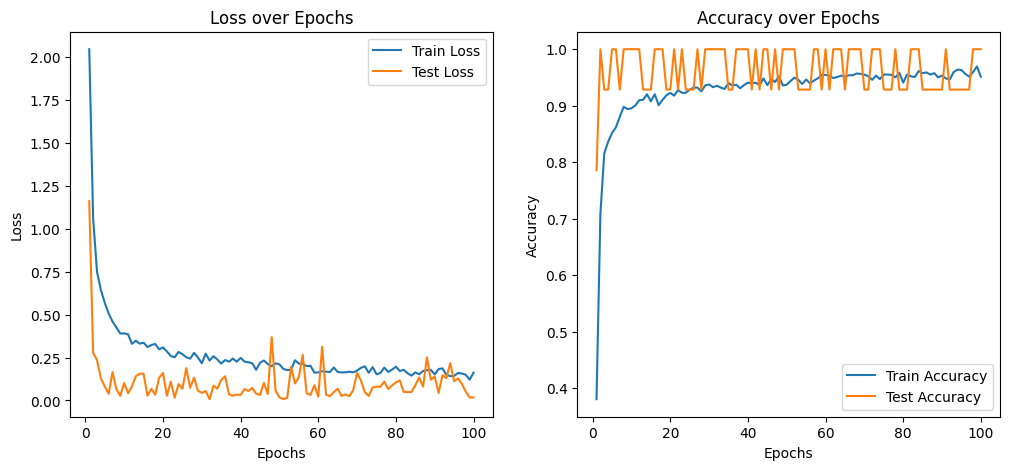

In [ ]:
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
# import os
# from PIL import Image
# import numpy as np

# def create_color_image(color, size=(64, 64)):
#     """Create a single-color image."""
#     image = Image.fromarray(np.full((size[1], size[0], 3), color, dtype=np.uint8))
#     return image

# def save_color_images(colors, save_dir, size=(64, 64), num_images=100):
#     """Save multiple single-color images."""
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     for i in range(num_images):
#         for color_name, color_value in colors.items():
#             image = create_color_image(color_value, size)
#             file_name = f"{color_name}_{i}.png"
#             file_path = os.path.join(save_dir, file_name)
#             image.save(file_path)

# # Define colors and their names
# colors = {
#     'black': (0, 0, 0),
#     'white': (255, 255, 255),
#     'red': (255, 0, 0),
#     'green': (0, 255, 0),
#     'blue': (0, 0, 255)
# }

# # Directory to save the generated images
# save_dir = 'data/train/empty'


# save_color_images(colors, save_dir, size=(64, 64), num_images=20)


In [ ]:
# from PIL import Image, ImageEnhance, ImageOps, ImageFilter
# import random
# import numpy as np
# import os

# def apply_transform(image):
#     """Apply a random transformation to the image."""
#     # Randomly choose a transformation to apply
#     transforms = [
#         lambda img: img.rotate(random.uniform(-1, 1)), 
#         lambda img: img.rotate(random.uniform(-2, 2)),
#         lambda img: img.rotate(random.uniform(-3, 3)),
#         lambda img: img.rotate(random.uniform(-4, 4)),
#         lambda img: img.rotate(random.uniform(-5, 5)),
#         lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2)),  # Random contrast
#         lambda img: ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2)),  # Random brightness
#         lambda img: ImageEnhance.Color(img).enhance(random.uniform(0.8, 1.2)),  # Random color enhancement
#         lambda img: ImageOps.mirror(img),  # Horizontal flip
#         lambda img: img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 2))),  # Random blur
#         lambda img: add_noise(img),  # Add random noise
#     ]
#     transform = random.choice(transforms)
#     return transform(image)

# def add_noise(image):
#     """Add random noise to the image."""
#     np_image = np.array(image)
#     noise = np.random.normal(0, 25, np_image.shape).astype(np.uint8)
#     np_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
#     return Image.fromarray(np_image)


# def duplicate_and_transform_images(root_dir, iter):
#     for color in ['black', 'white']:
#         color_dir = os.path.join(root_dir, color)
#         for piece in os.listdir(color_dir):
#             piece_dir = os.path.join(color_dir, piece)
#             if os.path.isdir(piece_dir):
#                 for img_name in os.listdir(piece_dir):
#                     if img_name.startswith("Screenshot"):
#                         img_path = os.path.join(piece_dir, img_name)
#                         with Image.open(img_path) as img:
#                             # Apply transformation
#                             transformed_img = apply_transform(img)
#                             # Save the new image
#                             new_img_name = img_name.replace("Screenshot", f"augmented_screenshot_{iter}")
#                             new_img_path = os.path.join(piece_dir, new_img_name)
#                             transformed_img.save(new_img_path)

# # Define the root directory
# root_dir = '/Users/leopoldstevens/Documents/GitHub/CC-1/data/train'

# for i in range(100):
#     duplicate_and_transform_images(root_dir, i)


In [ ]:
# def duplicate_and_transform_images_in_empty(root_dir, iterations):
#     empty_dir = os.path.join(root_dir, 'empty')
#     for img_name in os.listdir(empty_dir):
#         if img_name.startswith("Screenshot"):
#             img_path = os.path.join(empty_dir, img_name)
#             with Image.open(img_path) as img:
#                 for i in range(iterations):
#                     # Apply transformation
#                     transformed_img = apply_transform(img)
#                     # Save the new image
#                     new_img_name = img_name.replace("Screenshot", f"augmented_screenshot_{i}")
#                     new_img_path = os.path.join(empty_dir, new_img_name)
#                     transformed_img.save(new_img_path)

# # Define the root directory
# root_dir = '/Users/leopoldstevens/Documents/GitHub/CC-1/data/train'

# # Number of iterations for augmentation
# iterations = 100

# # Augment images in the 'empty' directory
# duplicate_and_transform_images_in_empty(root_dir, iterations)

Cell (0, 1): black_queen with probability 0.91
Cell (0, 3): black_knight with probability 0.97
Cell (0, 5): black_king with probability 0.98
Cell (1, 6): black_bishop with probability 0.95
Cell (2, 2): white_pawn with probability 1.00
Cell (2, 7): black_rook with probability 0.96
Cell (3, 1): white_pawn with probability 1.00
Cell (3, 2): black_pawn with probability 0.96
Cell (5, 5): white_bishop with probability 1.00
Cell (5, 6): white_knight with probability 1.00
Cell (7, 2): white_king with probability 0.99
Cell (7, 4): white_queen with probability 0.92
Cell (7, 5): white_rook with probability 1.00


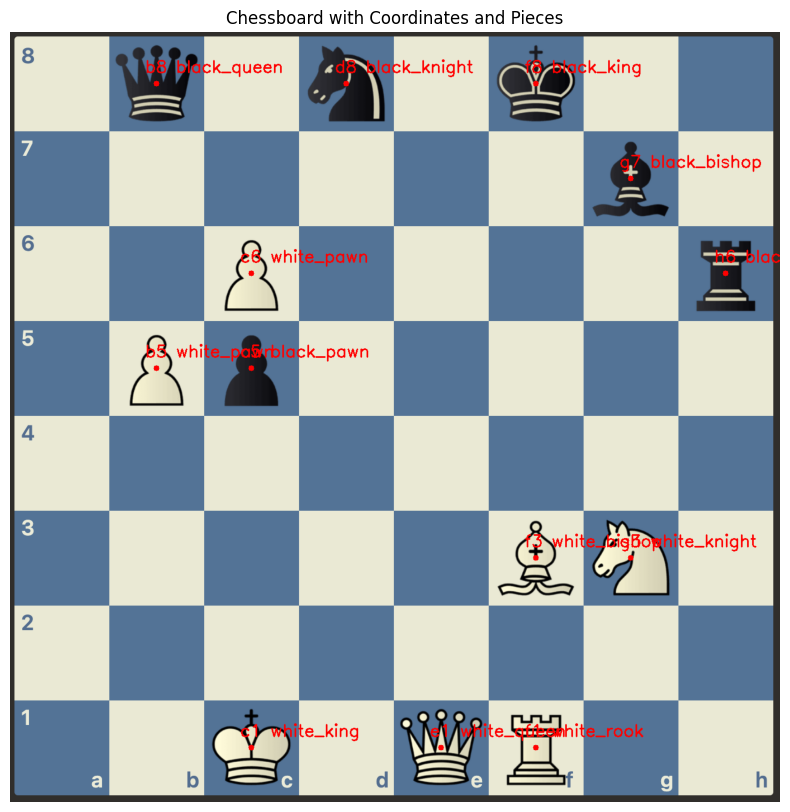

In [ ]:
from torchvision.transforms import functional as TF

model = ChessPieceCNN(num_classes=13)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define a function to process each cell
def process_cell(image, model, transform):
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1).squeeze(0)
    return probabilities

# Find intersections of lines
def find_intersections(lines, image_shape):
    intersections = []
    if lines is None:
        return intersections
    for line1, line2 in itertools.combinations(lines, 2):
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        A = np.array([
            [np.cos(theta1), np.sin(theta1)],
            [np.cos(theta2), np.sin(theta2)]
        ])
        b = np.array([[rho1], [rho2]])
        if np.linalg.det(A) != 0:  # Lines are not parallel
            x0, y0 = np.linalg.solve(A, b)
            x0, y0 = int(np.round(x0)), int(np.round(y0))
            if 0 <= x0 < image_shape[1] and 0 <= y0 < image_shape[0]:  # Within image bounds
                intersections.append((x0, y0))
    return intersections

# Sort intersections into a grid
def sort_intersections(intersections):
    intersections.sort(key=lambda x: (x[1], x[0]))  # Sort by y, then by x
    grid = []
    grid_size = 9  # 8x8 board has 9 lines
    for i in range(0, len(intersections), grid_size):
        row = sorted(intersections[i:i + grid_size], key=lambda x: x[0])
        grid.append(row)
    return grid

# Function to classify each cell in the chessboard
def classify_chessboard(image_path, model, transform):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)

    intersections = find_intersections(lines, image.shape)
    grid = sort_intersections(intersections)

    # Process each cell
    results = {}
    for i in range(8):
        for j in range(8):
            # Get the four corners of the square
            top_left = grid[i][j]
            top_right = grid[i][j + 1]
            bottom_left = grid[i + 1][j]
            bottom_right = grid[i + 1][j + 1]
            
            # Calculate the bounding box of the cell
            cell_image = image[top_left[1]:bottom_left[1], top_left[0]:top_right[0]]
            cell_image_pil = TF.to_pil_image(cell_image)
            probabilities = process_cell(cell_image_pil, model, transform)
            results[(i, j)] = probabilities
    
    return results, grid

# Example usage
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
results, grid = classify_chessboard(image_path, model, transform)

# Define the class names
class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook', 'black_pawn',
               'white_bishop', 'white_king', 'white_queen', 'white_knight', 'white_rook', 'white_pawn', 'empty']

# Print results and visualize
line_image = cv2.imread(image_path)
coordinate_labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

for coord, probs in results.items():
    piece_probs = {class_names[i]: probs[i].item() for i in range(len(class_names))}
    max_prob_piece = max(piece_probs, key=piece_probs.get)
    if max_prob_piece != 'empty':
        print(f"Cell {coord}: {max_prob_piece} with probability {piece_probs[max_prob_piece]:.2f}")
        
        top_left = grid[coord[0]][coord[1]]
        top_right = grid[coord[0]][coord[1] + 1]
        bottom_left = grid[coord[0] + 1][coord[1]]
        bottom_right = grid[coord[0] + 1][coord[1] + 1]
        
        center_x = (top_left[0] + top_right[0] + bottom_left[0] + bottom_right[0]) // 4
        center_y = (top_left[1] + top_right[1] + bottom_left[1] + bottom_right[1]) // 4
        
        label = f"{coordinate_labels[coord[1]]}{8 - coord[0]}"
        
        cv2.circle(line_image, (center_x, center_y), 5, (0, 0, 255), -1)
        cv2.putText(line_image, f"{label} {max_prob_piece}", (center_x - 20, center_y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Chessboard with Coordinates and Pieces")
plt.axis("off")
plt.show()

In [ ]:
import chess
import chess.engine

def setup_board(results, class_names):
    board = chess.Board()
    board.clear()

    piece_map = {
        'black_bishop': chess.BISHOP,
        'black_king': chess.KING,
        'black_queen': chess.QUEEN,
        'black_knight': chess.KNIGHT,
        'black_rook': chess.ROOK,
        'black_pawn': chess.PAWN,
        'white_bishop': chess.BISHOP,
        'white_king': chess.KING,
        'white_queen': chess.QUEEN,
        'white_knight': chess.KNIGHT,
        'white_rook': chess.ROOK,
        'white_pawn': chess.PAWN
    }

    color_map = {
        'black_bishop': chess.BLACK,
        'black_king': chess.BLACK,
        'black_queen': chess.BLACK,
        'black_knight': chess.BLACK,
        'black_rook': chess.BLACK,
        'black_pawn': chess.BLACK,
        'white_bishop': chess.WHITE,
        'white_king': chess.WHITE,
        'white_queen': chess.WHITE,
        'white_knight': chess.WHITE,
        'white_rook': chess.WHITE,
        'white_pawn': chess.WHITE
    }

    for coord, probs in results.items():
        piece_probs = {class_names[i]: probs[i].item() for i in range(len(class_names))}
        max_prob_piece = max(piece_probs, key=piece_probs.get)
        if max_prob_piece != 'empty':
            piece = piece_map[max_prob_piece]
            color = color_map[max_prob_piece]
            rank = 7 - coord[0]
            file = coord[1]
          
            square = chess.square(file, rank)
            board.set_piece_at(square, chess.Piece(piece, color))

    
    return board

# Define the class names
class_names = ['black_bishop', 'black_king', 'black_queen', 'black_knight', 'black_rook', 'black_pawn',
               'white_bishop', 'white_king', 'white_queen', 'white_knight', 'white_rook', 'white_pawn', 'empty']

results, _ = classify_chessboard(image_path, model, transform)

board = setup_board(results, class_names)
print(board)

stockfish_path = '/usr/local/bin/stockfish'

def get_best_moves(engine, board, depth=15, multipv=5):
    analysis = engine.analyse(board, chess.engine.Limit(depth=depth), multipv=multipv)
    best_moves = [entry['pv'][0] for entry in analysis]
    return best_moves

def describe_move(board, move):
    piece = board.piece_at(move.from_square)
    piece_name = piece.symbol().upper() if piece.color == chess.WHITE else piece.symbol().lower()
    from_square = chess.square_name(move.from_square)
    to_square = chess.square_name(move.to_square)
    target_piece = board.piece_at(move.to_square)
    
    if target_piece:
        target_piece_name = target_piece.symbol().upper() if target_piece.color == chess.WHITE else target_piece.symbol().lower()
        return f"{piece_name} at {from_square} takes {target_piece_name} at {to_square}"
    else:
        return f"{piece_name} at {from_square} goes to {to_square}"

with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    # Determine the current player
    current_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the current player
    best_moves_current = get_best_moves(engine, board)
    print(f"Best moves for {current_player}:")
    for i, move in enumerate(best_moves_current):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")
    
    # Switch the turn to the other player
    board.push(chess.Move.null())
    
    # Determine the other player
    other_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the other player
    best_moves_other = get_best_moves(engine, board)
    print(f"\nBest moves for {other_player}:")
    for i, move in enumerate(best_moves_other):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")

    # Undo the null move to restore the original turn
    board.pop()



. q . n . k . .
. . . . . . b .
. . P . . . . r
. P p . . . . .
. . . . . . . .
. . . . . B N .
. . . . . . . .
. . K . Q R . .


Not transmitting history with null moves to UCI engine


Best moves for White:
1. P at c6 goes to c7
2. B at f3 goes to h5
3. B at f3 goes to d5
4. N at g3 goes to h5
5. Q at e1 goes to e3

Best moves for Black:
1. n at d8 goes to f7
2. q at b8 goes to f4
3. r at h6 goes to f6
4. b at g7 goes to e5
5. b at g7 goes to b2


Not transmitting history with null moves to UCI engine


Best moves for White:
1. P at c6 goes to c7
2. B at f3 goes to h5
3. B at f3 goes to d5
4. N at g3 goes to h5
5. Q at e1 goes to e3

Best moves for Black:
1. n at d8 goes to f7
2. q at b8 goes to f4
3. r at h6 goes to f6
4. b at g7 goes to e5
5. b at g7 goes to b2


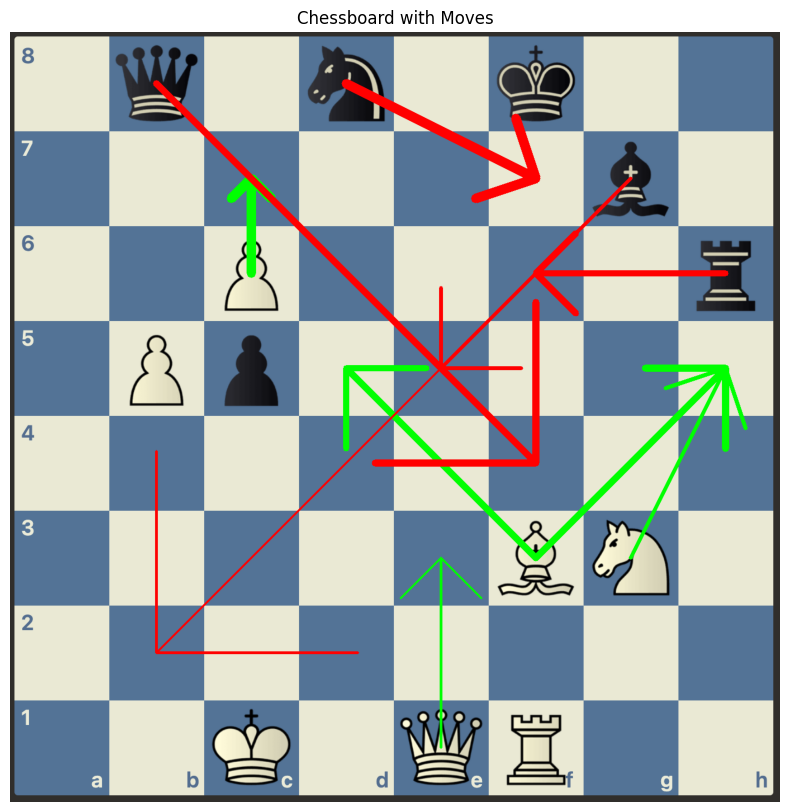

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.engine

def draw_arrows(image_path, best_moves_current, best_moves_other, board, grid):
    # Load the image
    image = cv2.imread(image_path)
    
    # Define a function to get the center of a square
    def get_square_center(rank, file):
        top_left = grid[7-rank][file]
        bottom_right = grid[7-rank+1][file+1]
        center_x = (top_left[0] + bottom_right[0]) // 2
        center_y = (top_left[1] + bottom_right[1]) // 2
        return center_x, center_y

    # Draw arrows for the current player (green)
    for i, move in enumerate(best_moves_current):
        from_square = move.from_square
        to_square = move.to_square
        
        from_rank = chess.square_rank(from_square)
        from_file = chess.square_file(from_square)
        to_rank = chess.square_rank(to_square)
        to_file = chess.square_file(to_square)
        
        from_center = get_square_center(from_rank, from_file)
        to_center = get_square_center(to_rank, to_file)
        
        # Draw the arrow
        color = (0, 255, 0)  # Green for the current player
        thickness = max(15 - 3*i, 1)  # Thicker for the best move, decreasing for subsequent moves
        cv2.arrowedLine(image, from_center, to_center, color, thickness, tipLength=0.3)

    # Draw arrows for the opponent (red)
    for i, move in enumerate(best_moves_other):
        from_square = move.from_square
        to_square = move.to_square
        
        from_rank = chess.square_rank(from_square)
        from_file = chess.square_file(from_square)
        to_rank = chess.square_rank(to_square)
        to_file = chess.square_file(to_square)
        
        from_center = get_square_center(from_rank, from_file)
        to_center = get_square_center(to_rank, to_file)
        
        # Draw the arrow
        color = (0, 0, 255)  # Red for the opponent
        thickness = max(15 - 3*i, 1)  # Thicker for the best move, decreasing for subsequent moves
        cv2.arrowedLine(image, from_center, to_center, color, thickness, tipLength=0.3)
    
    # Display the final image with arrows
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Chessboard with Moves")
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/Users/leopoldstevens/Documents/GitHub/CC-1/input/board.png"

# Assuming the results and grid are obtained from the classify_chessboard function
# results, grid = classify_chessboard(image_path, model, transform)
# Set up the board using the results
board = setup_board(results, class_names)

# Path to the Stockfish executable
stockfish_path = '/usr/local/bin/stockfish'

# Use Stockfish to find the best moves for the current turn
with chess.engine.SimpleEngine.popen_uci(stockfish_path) as engine:
    # Determine the current player
    current_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the current player
    best_moves_current = get_best_moves(engine, board)
    print(f"Best moves for {current_player}:")
    for i, move in enumerate(best_moves_current):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")
    
    # Switch the turn to the other player
    board.push(chess.Move.null())
    
    # Determine the other player
    other_player = "White" if board.turn == chess.WHITE else "Black"
    
    # Best moves for the other player
    best_moves_other = get_best_moves(engine, board)
    print(f"\nBest moves for {other_player}:")
    for i, move in enumerate(best_moves_other):
        descriptive_move = describe_move(board, move)
        print(f"{i + 1}. {descriptive_move}")

    # Undo the null move to restore the original turn
    board.pop()

    # Draw the arrows for the best moves
    draw_arrows(image_path, best_moves_current, best_moves_other, board, grid)


In [ ]:
import tkinter as tk

class ScreenRegionSelector:
    def __init__(self, root):
        self.root = root
        self.root.attributes("-fullscreen", True)
        self.root.attributes("-alpha", 0.3)
        self.root.bind("<Escape>", self.quit)
        
        self.canvas = tk.Canvas(self.root, cursor="cross", bg="gray")
        self.canvas.pack(fill=tk.BOTH, expand=True)
        
        self.start_x = None
        self.start_y = None
        self.rect = None
        self.rect_coords = None
        
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_move_press)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
    
    def on_button_press(self, event):
        self.start_x = self.canvas.canvasx(event.x)
        self.start_y = self.canvas.canvasy(event.y)
        if self.rect:
            self.canvas.delete(self.rect)
        self.rect = self.canvas.create_rectangle(self.start_x, self.start_y, self.start_x, self.start_y, outline='red', width=2)
    
    def on_move_press(self, event):
        cur_x = self.canvas.canvasx(event.x)
        cur_y = self.canvas.canvasy(event.y)
        self.canvas.coords(self.rect, self.start_x, self.start_y, cur_x, cur_y)
    
    def on_button_release(self, event):
        end_x = self.canvas.canvasx(event.x)
        end_y = self.canvas.canvasy(event.y)
        self.rect_coords = (self.start_x, self.start_y, end_x, end_y)
        print(f"Selected region: {self.rect_coords}")
        self.quit()
    
    def quit(self, event=None):
        self.root.destroy()

def main():
    root = tk.Tk()
    selector = ScreenRegionSelector(root)
    root.mainloop()
    return selector.rect_coords

selected_region = main()
print(f"Final selected region: {selected_region}")


Final selected region: None


: 